In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy import signal
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from numpy.linalg import inv
import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as I
from torch.nn import Sigmoid

from torch import transpose
from sklearn.neural_network import BernoulliRBM
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt

In [2]:
from helpers import *
#from nmf_utils import *
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Apply STFT :

## We can change :

* Window : Type of window
* nperseg : length of window
* noverlap : overlap between windows.
* nfft : fft length > window size

In [ ]:
!ffmpeg -i  "/content/drive/MyDrive/vocal_10.mp3" "vocal.wav"
!ffmpeg -i  "/content/drive/MyDrive/piano_10.mp3" "music.wav"

In [20]:

samplerate_m,music = read("music.wav")
music=music[:44100*1088,0]
length=music.shape[0]/samplerate_m
print('Shape of the music {}'.format(music.shape[0]))
print('Length : {:.2f}s'.format(length))
print('Sample rate : {}'.format(samplerate_m))


samplerate_s,speech = read("vocal.wav")
speech=speech[:44100*1088,0]

length=speech.shape[0]/samplerate_s
print('Shape of the speech {}'.format(speech.shape[0]))
print('Length : {:.2f}s'.format(length))
print('Sample rate : {}'.format(samplerate_s))



Shape of the music 47980800
Length : 1088.00s
Sample rate : 44100
Shape of the speech 47980800
Length : 1088.00s
Sample rate : 44100


## Low band Filter

In [21]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

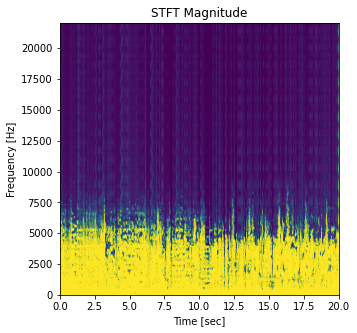

In [22]:
speech = butter_lowpass_filter(speech,4000,44100)
WINDOW = 'hamming'
WINDOW_SIZE=480
OVERLAP = 0.6 * WINDOW_SIZE
NFFT=512

f,t,M= signal.stft(speech[:44100*20],44100,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)    # spectrum  of music signal
Viz_Y(t,f,np.abs(M), vmin=0, vmax=20)


## Resampling

In [23]:
from scipy import signal

In [24]:
rate = 44100/16000
speech = signal.resample(speech,int(speech.shape[0]/rate))
music=signal.resample(music,int(music.shape[0]/rate))
samplerate_m=int(samplerate_m/rate)
samplerate_s=samplerate_m
samplerate_t=samplerate_m

In [25]:
samplerate_t

16000

# Train / Validation

In [26]:
train_speech   = speech[samplerate_t*60:samplerate_t*440]
train_music    = music[samplerate_t*60:samplerate_t*440]

test_speech ,  test_music =  speech[samplerate_t*440:samplerate_t*470]  , music[samplerate_t*440:samplerate_t*470]


In [27]:
SMR(train_speech,train_music)

SMR = 2.97


2.9724765624617415

# NMF

In [28]:
#from helpers import *

def speech_nmf(Y,n_component,max_iter,a,initt):


  Y[Y==0]=0.0001
  model = NMF(n_components=n_component,
            init=initt,
            alpha=a,
            beta_loss='itakura-saito',
            solver="mu",
            max_iter=max_iter,
            random_state=0)
  B = model.fit_transform(Y)
  G = model.components_
  return B,G, model.reconstruction_err_
def music_nmf(Y,n_component,max_iter,a,initt):


  Y[Y==0]=0.0001
  model = NMF(n_components=n_component,
            init=initt,
            alpha=a,
            beta_loss='itakura-saito',
            solver="mu",
            max_iter=max_iter,
            random_state=0)
  B = model.fit_transform(Y)
  G = model.components_
  return B,G, model.reconstruction_err_




In [29]:
def Reconstruct(B,G,Ns,Nm,Yabs,p):
    
    numerators=[]
    B1=B[:,:Ns]
    B2=B[:,Ns:]
    G1=G[:Ns,:]
    G2=G[Ns:,:]
    
    
    numerators.append(np.power(np.matmul(B1,G1),p))
    numerators.append(np.power(np.matmul(B2,G2),p))

    denominator = np.power(np.matmul(B1,G1),p)+np.power(np.matmul(B2,G2),p)
  
    

    Sources=[]
    Masks=[]
    for i in range(2):

        Sources.append(np.multiply(numerators[i]/denominator,Yabs))
        Masks.append(numerators[i]/denominator)

    #print('Source shape = {}'.format(Sources[0].shape))
    
    return Sources,Masks
def training(music_s,
               speech_s,
                          init,

               s_component = 128,
               m_component = 128,
               iterations = 200,
               s_alpha = 0,
               m_alpha = 0,
               p = 2,
             samplerate=samplerate_t,
                ):
  ###################################   STFT   #######################################
  WINDOW = 'hamming'
  WINDOW_SIZE=480
  OVERLAP = 0.6 * WINDOW_SIZE
  NFFT=512
  #_,speech_s,music_s = get_mixed_signal(spe)

  f,t,M= signal.stft(music_s,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)    # spectrum  of music signal

  f,t,S= signal.stft(speech_s,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)   # spectrum  of speech signal

  #####################################################################################


  ## Magnitude of each spectrum source 

  M_abs=np.abs(M)

  S_abs=np.abs(S)




  ##############################   NMF Training   #####################################
  print("Training Stage ....")
  B_speech,_,error_speech = speech_nmf(S_abs,s_component,iterations,s_alpha,initt=init)
  B_music,_,error_music =   music_nmf(M_abs,m_component,iterations,m_alpha,initt=init)
  print("Training finish ! ....")

  #####################################################################################

  B_mixed = np.concatenate([B_speech,B_music],axis = 1)                                # Concatenation of both  training dictionnaries
  print("SPEECH reconstruction Loss {}".format(error_speech))
  print("MUSIC reconstruction Loss {}".format(error_music))

  return B_mixed

In [30]:
def mixed_nmf(B_mixed,
              Y_test,
              iterations,
              a,
              initt,
              ):
  n_components=B_mixed.shape[1]
  model = NMF(n_components=n_components,
              init=initt,
              alpha=a,
              beta_loss='itakura-saito',
              solver="mu",
              max_iter=iterations,
              random_state=0)
  
  model.fit(np.transpose(Y_test))

  model.components_ = np.transpose(B_mixed)

  G0 = model.transform(np.transpose(Y_test))

  return np.transpose(G0),model.reconstruction_err_,model.components_

In [31]:
def validation(B_mixed,
               speech,
               music,
               s_component,
               m_component,
               alpha,
               init,
               smr,
               iterations,
               samplerate=samplerate_t
               ):

  mixed_signal , speech_signal, music_signal = get_mixed_signal(speech,music,smr)
  #mixed_signal = mixed_signal
  WINDOW = 'hamming'
  WINDOW_SIZE=480
  OVERLAP = 0.6 * WINDOW_SIZE
  NFFT=512

  f,t,mixed_spectrum = signal.stft(mixed_signal,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT) # spectrum  of mixed signal

  mixed_abs = np.abs(mixed_spectrum)
  G_mixed,reconstruction,update_or_not = mixed_nmf(B_mixed,
              mixed_abs,
              iterations,
              alpha,
              init
              )
  #B_mixed,G_mixed,error_speech = speech_nmf(mixed_abs,s_component,iterations,0)
  print("ok")
  sources,masks = Reconstruct(B_mixed,
                              G_mixed,
                              s_component,
                              m_component,
                              mixed_spectrum,
                              2)
  _, speech_estimate =  signal.istft( sources[0],samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
  _, music_estimate =    signal.istft(sources[1],samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
  print("Separation finish ! ....")
  #print(speech_estimate.shape, speech.shape)
  sdr_speech = SDR(speech_estimate[:speech_signal.shape[0]],speech_signal)
  
  sdr_music = SDR(music_estimate[:music_signal.shape[0]],music_signal)
  print("Evaluation .....")
  #print(update_or_not)
  print("SMR ={} N_components ={}: \nSDR Speech = {}\nSDR Music  = {}".format(smr,s_component,sdr_speech,sdr_music))
  print(reconstruction)

  write("Speech{}.wav".format(iterations), samplerate, speech_estimate.astype(np.int16))
  write("Music.wav".format(iterations), samplerate, music_estimate.astype(np.int16))
  return smr,sdr_speech,sdr_music,update_or_not

In [32]:
B_all_list= []
for c in [10]:
  B_mixed = training(train_music,
               train_speech,
               s_component = c,
               m_component = c,
               iterations = 100,
               s_alpha = 0,
               m_alpha = 0,
               p = 2,
               init="random")
  B_mixed_new = MinMaxScaler().fit_transform(B_mixed)
  B_all_list.append(B_mixed_new)

Training Stage ....
Training finish ! ....
SPEECH reconstruction Loss 2425.399027640006
MUSIC reconstruction Loss 1996.4948484614656


In [33]:
my_dict_2= {}
info_dict_2 = {}  
for i in range(len(B_all_list)):
  Q = np.int(B_all_list[i].shape[1] / 2 )
  for s in [-5,0,5]:
    smr,sdr_speech,sdr_music,_ = validation(B_all_list[i],test_speech,
                  test_music,
                  smr=s,
                  iterations=100,
                  m_component=Q,
                  s_component=Q,
                  alpha=0,
                  init="random"
)
    my_dict_2["SMR = {} n_component = {}".format(smr,Q)] = info_dict_2 = ["SDR Speech = {:.2f} SDR Music = {:.2f}".format(sdr_speech,sdr_music)]


SMR = -5.00
ok
Separation finish ! ....
Evaluation .....
SMR =-5 N_components =10: 
SDR Speech = 1.1151919586761008
SDR Music  = 6.1151919586761005
543.6317866983599
ok
Separation finish ! ....
Evaluation .....
SMR =0 N_components =10: 
SDR Speech = 3.985964068281835
SDR Music  = 1.588340614541584
565.6696476312368
SMR = 5.00
ok
Separation finish ! ....
Evaluation .....
SMR =5 N_components =10: 
SDR Speech = 4.606970111883103
SDR Music  = -0.39302988811689776
570.267439327192


• Test with different FC (low band filter)

• DNN

In [ ]:
my_dict_2= {}
info_dict_2 = {}
list_speech = []
list_music = []
list_smr = []
smr_arange = np.arange(-5,5,0.1)
for it in [100]:
  for i in range(len(B_all_list)):
    Q = np.int(B_all_list[i].shape[1] / 2 )
    for s in smr_arange:
      smr,sdr_speech,sdr_music,_ = validation(B_all_list[i],test_speech,
                    test_music,
                    smr=s,
                    iterations=it,
                    m_component=Q,
                    s_component=Q,
                    alpha=0,
                    init="random"
)
      #my_dict_2["SMR = {} n_component = {}".format(smr,Q)] = info_dict_2 = ["SDR Speech = {:.2f} SDR Music = {:.2f}".format(sdr_speech,sdr_music)]
      list_speech.append(sdr_speech)
      list_music.append(sdr_music)
      list_smr.append(smr)


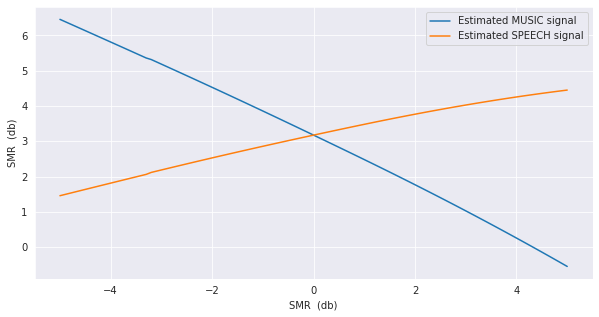

In [60]:
my_dict

{'SMR = -5 n_component = 1': ['SDR Speech = 0.96 SDR Music = 5.96'],
 'SMR = -5 n_component = 10': ['SDR Speech = 1.46 SDR Music = 6.46'],
 'SMR = -5 n_component = 32': ['SDR Speech = 1.56 SDR Music = 6.56'],
 'SMR = -5 n_component = 64': ['SDR Speech = 0.74 SDR Music = 5.74'],
 'SMR = 0 n_component = 1': ['SDR Speech = 1.53 SDR Music = -0.93'],
 'SMR = 0 n_component = 10': ['SDR Speech = 3.89 SDR Music = 1.43'],
 'SMR = 0 n_component = 32': ['SDR Speech = 3.65 SDR Music = 1.19'],
 'SMR = 0 n_component = 64': ['SDR Speech = 3.35 SDR Music = 0.90'],
 'SMR = 5 n_component = 1': ['SDR Speech = 1.59 SDR Music = -3.41'],
 'SMR = 5 n_component = 10': ['SDR Speech = 4.45 SDR Music = -0.55'],
 'SMR = 5 n_component = 32': ['SDR Speech = 4.02 SDR Music = -0.98'],
 'SMR = 5 n_component = 64': ['SDR Speech = 3.64 SDR Music = -1.36']}

In [70]:
my_dict_2

{'SMR = -5 n_component = 10': ['SDR Speech = 0.55 SDR Music = 5.55'],
 'SMR = -5 n_component = 2': ['SDR Speech = 0.97 SDR Music = 5.97'],
 'SMR = -5 n_component = 32': ['SDR Speech = 0.65 SDR Music = 5.65'],
 'SMR = -5 n_component = 4': ['SDR Speech = 1.38 SDR Music = 6.38'],
 'SMR = 0 n_component = 10': ['SDR Speech = 3.62 SDR Music = 1.16'],
 'SMR = 0 n_component = 2': ['SDR Speech = 3.44 SDR Music = 0.98'],
 'SMR = 0 n_component = 32': ['SDR Speech = 3.61 SDR Music = 1.15'],
 'SMR = 0 n_component = 4': ['SDR Speech = 3.27 SDR Music = 0.81'],
 'SMR = 5 n_component = 10': ['SDR Speech = 3.89 SDR Music = -1.11'],
 'SMR = 5 n_component = 2': ['SDR Speech = 3.64 SDR Music = -1.36'],
 'SMR = 5 n_component = 32': ['SDR Speech = 3.85 SDR Music = -1.15'],
 'SMR = 5 n_component = 4': ['SDR Speech = 3.42 SDR Music = -1.58']}